In [193]:
from typing import Dict, List, Tuple
from gurobipy import Model, QuadExpr, LinExpr, GRB, Var
import numpy as np
import warnings
import os

from cvxpy import Variable, quad_form, Minimize, Problem
from commonroad.scenario.trajectory import State
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.common.util import Interval
from commonroad_dc.pycrccosy import CurvilinearCoordinateSystem

from scipy.interpolate import interp1d
from utils import compute_orientation_from_polyline

from commonroad_route_planner.route_planner import RoutePlanner


class ScenarioParams:
    verbose = True

    ### scenario options ###############################
    dt = 0.1

    ## vehicle dynamics
    length = 5
    width = 2
    a_max_total = 9.81 # lateral and longitudinal acceleration combined
    lat_v_max = 5.0

    # longitudinal_planning
    min_dist_long = 5
    nx = 3
    a_min = -7.0
    a_max = 1.5 #9.81
    j_min = -0.15e2
    j_max = 0.15e2
    v_min = 0
    v_max = 50
    s_bounds = [0, 200]  # width of initial s interval

    ### mixed integer optimization ###############################
    M_s = 300 # big M variable

    # lateral planning
    lat_j_max = 1e4
    sys_lat_nx = 3
    sys_lat_nu = 1
    Q = np.diag([5,1,1]) # weights for position, velocity and acceleration
    R = np.diag([0.5]) # weights for input (jerk)

    ### lane options ##############################################
    reference_resampling = 1.0  #resampling center line of lanes
    lane_width = 2.0

    #### derived values ##########################################
    lane_width_half = lane_width * .5
    ds_long = length + min_dist_long
    dt_2 = pow(dt,2) / 2
    dt_3 = pow(dt,3) / 6
    a_max_sq = a_max_total ** 2

    s_min = [0, v_min, a_min]
    s_max = [0, v_max, a_max]


def get_gurobi_variable_float(var):
    """Returns float expression of any gurobi variable"""
    if type(var) == Var:
        return var.X
    elif type(var) in (QuadExpr, LinExpr):
        return var.getValue()
    elif isinstance(var, (int, float)):
        return var
    else:
        ValueError('Unknown type: {}'.format(type(var)))

class Constraints:
    def __init__(self, x_target:np.ndarray, x_min:np.ndarray, x_max:np.ndarray):
        self.d_target = x_target
        self.x_min = x_min
        self.x_max = x_max

    @property
    def n_steps(self):
        return self.d_target.size

class CurvState:
    def __init__(self, s, ds, dds, d=None, dd=None, ddd=None):
        """"""
        # longitudinal
        self.s = s
        self.ds = ds
        self.dds = dds
        # lateral
        self.d = d
        self.dd = dd
        self.ddd = ddd

    @property
    def s_float(self):
        return get_gurobi_variable_float(self.s)

    @property
    def d_float(self):
        return get_gurobi_variable_float(self.d)

    @property
    def ds_float(self):
        return get_gurobi_variable_float(self.ds)

    @property
    def dds_float(self):
        return get_gurobi_variable_float(self.dds)


class GurobiStatelist:
    def __init__(self, model:Model, var_u, var_x, n_time_steps: int, eg_motion, curv_sys:CurvilinearCoordinateSystem, dt:float):
        self.n_time_steps = n_time_steps
        self.eg_motion = eg_motion # jerkmotion 
        self.curv_sys = curv_sys
        self.model = model
        self.dt = dt
        self.var_u = var_u
        self.var_x = var_x
        self.state_list: List[CurvState] = self._init_state_list() #* add constraints of dynamic equations

    @property
    def state_list_cr(self) -> List[State]:
        state_list = []
        pos_array = []
        for t, state in enumerate(self.state_list):
            pos = np.array([state.s_float, state.d_float])
            pos_array.append(pos)
            state_list.append(State(time_step=t, position=pos, velocity=state.ds_float, acceleration=state.dds_float))

        orientations = compute_orientation_from_polyline(np.array(pos_array))
        for t, state in enumerate(state_list):
            state.orientation = orientations[t]

        return state_list

    def _init_state_list(self):
        #* add constraints of dynamic equations
        state_list = []
        for t in range(self.n_time_steps):
            var_xk = self.var_x[:,t] #* state at time step t
            state_list.append(self.eg_motion.simulate_long(self.model, var_xk, self.var_x[:,t+1],
                                                           self.var_u[t], self.dt))
        return state_list

    def compute_lateral_offset_of_lane(self, target_center_line: np.ndarray, time_interval: Interval) -> np.ndarray:
        """Computes offset of center line from lane at each long position of state_list in curvilinear coordinates."""

        d_target = []
        # create mapping from longitudinal coordinate to d
        pos_map = []
        for vert in target_center_line:
            try:
                pos_map.append(self.curv_sys.convert_to_curvilinear_coords(vert[0], vert[1])) # from longitudinal coordinate to d
            except:
                if len(pos_map)>0:
                    warnings.warn('Lanes might diverge after s= {}!'.format(pos_map[-1][0]))
                    # raise ValueError('Lanes might diverge after s= {}!'.format(pos_map[-1][0]))
                else:
                    # projection domain not yet reached
                    warnings.warn('Vehicle not in lane!')
                    continue

        # find d_target at each long. position
        self.pos_map = np.array(pos_map)
        f_interpolate = interp1d(self.pos_map[:, 0], self.pos_map[:, 1], fill_value='extrapolate')

        if self.state_list[time_interval.start].s_float < self.pos_map[0,0] - 10\
            or self.state_list[time_interval.end].s_float > self.pos_map[-1,0] + 10:
            warnings.warn('Vehicle not in lane!', stacklevel=2)

        for state in self.state_list[time_interval.start:time_interval.end+1]:
            d_target.append(f_interpolate(state.s_float))

        return np.array(d_target)


class JerkMotion:
    constr_counter = 0

    def __init__(self):
        self.x0 = None

    def simulate_long(self, model, var_x_k, var_x_kp, var_u, dt:float):
        # longitudinal motion
        dt_2 = pow(dt, 2) / 2
        dt_3 = pow(dt, 3) / 6
        # U JERK
        A = np.array(
            [[1,  dt, dt_2],
             [0, 1, dt  ],
             [0, 0, 1]])
        B = np.array(
            [[dt_3, ],
             [dt_2, ],
             [dt,   ]])

        var_x_k = var_x_k.reshape([-1,1])
        x_prop = A.dot(var_x_k) + B.dot(var_u)

        # constraints for enforcing consistency of motion
        for i_x in range(var_x_k.size):
            model.addConstr(var_x_kp[i_x] == x_prop[i_x,0],"state_trans{}".format(JerkMotion.constr_counter))
            JerkMotion.constr_counter += 1

        return CurvState(# s=x_k.s + x_k.ds * dt + 0.5 * dt**2 * x_k.dds + 1/6 * dt**3 * u,
                         s =  var_x_k.flatten()[0],
                         # ds= x_k.ds  + x_k.dds * dt + 0.5 * dt**2 * u,
                         ds = var_x_k.flatten()[1],
                         dds = var_x_k.flatten()[2],
                         # dds=x_k.dds + dt * u,
                         d = 0)

    def simulate_lat(self, x_k: CurvState, x_k_next:CurvState, u, dt:float):
        # lateral motion
        x_k_next.d = x_k.d + x_k.dd * dt + 0.5 * dt**2 * x_k.ddd + 1/6 * dt**3 * u
        x_k_next.dd = x_k.dd + x_k.ddd * dt + 0.5 * dt ** 2 * u
        x_k_next.ddd = x_k_next.ddd + dt * u


class MIQPPlanner:
    def __init__(self, s0: CurvState, n_time_steps: int, min_duration:List[float], dt:float, curv_sys: CurvilinearCoordinateSystem, params:ScenarioParams=ScenarioParams):
        """
        Planner for lane changes using Mixed Integer Quadratic Programming.
        :param s0: initial state of vehicle
        :param n_time_steps: number of time steps
        :param min_duration: minimal duration of each mode len(min_duration)=3
        :param dt: duration of each time_step
        :param params: parameters
        """
        assert sum(min_duration) <= n_time_steps*dt, 'Durations ({}) have to be <= n_time_steps*dt ({})'.format(sum(min_duration), n_time_steps*dt)
        self.model = Model('')
        self.s0 = s0
        self.n_time_steps = n_time_steps
        self.mode_durations = {}
        self.min_duration = min_duration
        self.dt = dt
        self.params = params
        self._init_mode_variables() #* B(mode indicator)
        self.var_x, self.var_u = self._init_state_variables(self.params.s_bounds, self.model, self.s0) #* input u and state x
        self.states = GurobiStatelist(self.model, self.var_u, self.var_x, self.n_time_steps, JerkMotion(), curv_sys, self.params.dt)
        self.costs = self._init_costs(self.states)

    def _init_state_variables(self, bounds_s, model: Model, s0:CurvState):
        # gurobi variables #
        # input
        var_u = [model.addVar(lb=self.params.j_min, ub=self.params.j_max, vtype=GRB.CONTINUOUS, name="u{}".format(t)) for t in
                      range(self.n_time_steps)] #* u for each time step, float, [j_min, j_man]

        # states
        var_x = np.empty([self.params.nx,self.n_time_steps+1],dtype=object) #* 3 * n_time_steps+1
        for t in range(self.n_time_steps + 1):
            for i_x in range(self.params.nx):
                if i_x == 0:
                    lb = bounds_s[0] + self.params.s_min[1] * self.params.dt * t # minimal velocity * time
                    ub = bounds_s[1] + max(self.params.s_max[1], self.params.v_max) * self.params.dt * t# maximal velocity * time
                else:
                    lb = self.params.s_min[i_x] # velocity or acceleration
                    ub = self.params.s_max[i_x]

                var_x[i_x,t] = model.addVar(lb=lb, ub=ub, vtype=GRB.CONTINUOUS, name="x{}_t{}".format(i_x, t))

        # initial state constraints
        if s0.s is not None:
            model.addConstr(var_x[0, 0] == self.s0.s, 'init_state_s0')
        if s0.ds is not None:
            model.addConstr(var_x[1, 0] == self.s0.ds, 'init_state_ds0')
        if s0.dds is not None:
            model.addConstr(var_x[2, 0] == self.s0.dds, 'init_state_dds0')

        return var_x, var_u

    def _init_mode_variables(self):
        """Initializes binary variables for encoding modes and constrains their order and length."""
        #* BINARY variables: (3 X n_time_steps) b{}_{}
        self.B = {}
        for mode_id in range(3):
            b_tmp = []
            for k in range(self.n_time_steps):
                b_tmp.append(self.model.addVar(vtype=GRB.BINARY, name="b{}_{}".format(mode_id, k)))

            self.B[mode_id] = np.array(b_tmp)

        # add_switching_constraints()
        self.model.addConstr(self.B[0][0] == 1, "init_mode")

        for mode_id in range(3):
            if mode_id < 2:
                mode_id_next = mode_id + 1
            else:
                mode_id_next = None

            self.mode_durations[mode_id] = 0.0
            for t in range(len(self.B[mode_id])):
                if mode_id < 2:
                    self.mode_durations[mode_id] += self.B[mode_id][t] - self.B[mode_id_next][t]
                else:
                    self.mode_durations[mode_id] += self.B[mode_id][t]

                if t < len(self.B[mode_id]) - 1:
                    self.model.addConstr(self.B[mode_id][t] <= self.B[mode_id][t + 1],
                                "one_switch_{}_{}".format(mode_id, t))  # binary variable activated once
                if mode_id < 2: #* only 100->110->111 allowed 
                    self.model.addConstr(self.B[mode_id][t] >= self.B[mode_id_next][t], "mode_order{}_{}".format(mode_id, t))  # defines order of modes
            #! delate a indent here 
            self.model.addConstr(self.mode_durations[mode_id] >= np.ceil(self.min_duration[mode_id] / self.dt),
                                     "mode_duration_min_{}".format(mode_id))  # abs_min. duration of mode

    def mode_is_active(self, mode_id: int) -> np.ndarray:
        """Returns 1 when mode is active"""
        if mode_id in range(2): #? Todo of author: originally 3
            return self.B[mode_id] - self.B[mode_id+1]
        else:
            return self.B[mode_id]

    def _init_costs(self, states: GurobiStatelist, slack_variables=None):
        """Computes quadratic costs for jerk and acceleration."""
        #? Todo of author: add costs for slack variables for s_constraints
        costs = QuadExpr()
        w_j = 0.01
        w_a = 10
        for state in states.state_list:
            costs.add(state.dds * (state.dds) * w_a)  # squared a

        for j in states.var_u:
            costs.add(j * j * w_j) # squared jerk

        return costs

    def set_long_constraints(self, s_constraints: List[np.ndarray]):
        """
        Sets longitudinal constraints
        :param s_constraints: abs_min/abs_max constraints in each lane at each time_step. List[np.ndarray: 2 x n_time_steps]
        :return:
        """
        assert len(s_constraints) == 3, 'Number of constraints has to equal 3, but is {}.'.format(len(s_constraints))

        for mode_id, s_minmax in enumerate(s_constraints):
            b_active = self.mode_is_active(mode_id) # symbolic equation [20,]
            for t, b_tmp in enumerate(b_active): # t: 0-20
                #? Todo of author: add slack variables for s_constraints
                self.model.addConstr( #* feasible region for each mode
                    s_minmax[t, 0] - (1 - b_active[t]) * self.params.M_s <= self.states.state_list[t].s,
                    "s_min_t{}".format(t))
                self.model.addConstr(
                    s_minmax[t, 1] + (1 - b_active[t]) * self.params.M_s >= self.states.state_list[t].s,
                    "s_max_t{}".format(t))

    def _get_time_intervals_from_solution(self) -> List[Interval]:
        """Time intervals: {mode_id,Interval(time step when activated, last time step when active)}"""
        time_intervals = []
        for mode_id in range(3):
            b_array = self.mode_is_active(mode_id)
            t_start = None
            t_end = b_array.size - 1
            for t, b in enumerate(b_array):
                active = bool(round(get_gurobi_variable_float(b)))
                if t_start == None:
                    if active:
                        t_start = t
                elif active is False:
                    t_end = t - 1
                    break

            time_intervals.append(Interval(t_start, t_end))

        return time_intervals

    def solve_longitudinal(self) -> Tuple[List[State], List[Interval]]:
        # construct constraints    
        self.model.setObjective(self.costs, GRB.MINIMIZE)
        self.model.update()
        print('Update succeeds.')
        # try:
        #     self.model.computeIIS()
        #     print('model is infeasible')
        #     self.model.write('/home/klischat/Desktop/out.ilp')
        # except:
        #     if self.params.verbose is True:
        #         print('model is feasible')
        # self.model.solve()
        self.model.optimize()
        print('Optimize ends.')
        print(self.model.status)

        # extract time intervals for each mode
        time_intervals = self._get_time_intervals_from_solution()
        return self.states.state_list_cr, time_intervals

    def _create_lateral_constraints(self, target_center_line: np.ndarray, time_intervals: List[Interval]) -> Constraints:
        """Create reference and constraints for lateral position d."""
        d_target = []
        d_min = []
        d_max = []
        for mode_id in range(3):
            time_interval = time_intervals[mode_id]
            d_target.append(self.states.compute_lateral_offset_of_lane(target_center_line, time_interval))

            # special case for lane change mode
            if mode_id==1:
                d_ref_prev = d_target[-2][-1]
                d_min.append(np.minimum(d_ref_prev   - self.params.lane_width_half,
                                        d_target[-1] - self.params.lane_width_half))
                # upper bounds
                d_max.append(np.maximum(d_ref_prev   + self.params.lane_width_half,
                                        d_target[-1] + self.params.lane_width_half))
            else:
                d_min.append(d_target[-1] - self.params.lane_width_half)
                d_max.append(d_target[-1] + self.params.lane_width_half)

        lateral_constraints = Constraints(np.concatenate(d_target), np.concatenate(d_min), np.concatenate(d_max))

        return lateral_constraints

    def solve_lateral(self, target_center_line: np.ndarray, time_intervals: List[Interval]):
        constraints = self._create_lateral_constraints(target_center_line, time_intervals)

        var_x = Variable((self.params.sys_lat_nx, constraints.n_steps + 1))
        var_u = Variable((self.params.sys_lat_nu, constraints.n_steps))
        opt_problems: List[Problem] = []
        A = np.array(
            [[1.0, self.params.dt, self.params.dt_2],
             [0.0, 1.0,            self.params.dt  ],
             [0.0, 0.0,            0.0             ]])
        B = np.array(
            [[self.params.dt_3, ],
             [self.params.dt_2, ],
             [self.params.dt,   ]])

        # lateral target states
        x_target = np.vstack((constraints.d_target, np.zeros((self.params.sys_lat_nx - 1,constraints.n_steps))))

        # initial condition
        c0 = var_x[:,0] == np.array([constraints.d_target[0], 0.0, 0.0]).transpose()

        for t in range(constraints.n_steps):
            # constraints
            a_max = np.sqrt(self.params.a_max_sq - self.states.state_list[t].dds_float**2)
            x_min = np.array([constraints.x_min[t], -self.params.lat_v_max, -a_max]).transpose()
            x_max = np.array([constraints.x_max[t],  self.params.lat_v_max,  a_max]).transpose()
            c = [var_x[:, t + 1] == A * var_x[:, t] + B * var_u[:,t],
                 var_x[:, t]     >= x_min,
                 var_x[:, t]     <= x_max,
                 var_u[:,t]      >= -self.params.lat_j_max,
                 var_u[:,t]      <= self.params.lat_j_max]

            # costs
            J = quad_form(var_x[:,t] - x_target[:, t], self.params.Q) + quad_form(var_u[:,t], self.params.R)

            opt_problems.append(Problem(Minimize(J),c))

        opt_problem = sum(opt_problems)
        opt_problem.constraints.append(c0)
        opt_problem.solve(verbose=self.params.verbose)

        # extract solution
        self._extract_lateral_trajectory(var_x)

    def _extract_lateral_trajectory(self, var_x: Variable):
        # write solution to state
        for t, state in enumerate(self.states.state_list):
            state.d = var_x[0, t].value
            state.dd = var_x[1, t].value
            state.ddd = var_x[2, t].value


    

## `Planning problem defined in scenario`

In [194]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import clear_output
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad_route_planner.utility.visualization import visualize_route

scenario_path = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), "../scenarios/ZAM_Tutorial-1_2_T-1.xml"))
scenario, planning_problem_set = CommonRoadFileReader(scenario_path).open()
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0] #* get the first(and the only one) planning_problem_dict value
# print(planning_problem_set.planning_problem_dict.keys()) #* only one problem in the set

#! planning_problem goal is empty.
goal = planning_problem.goal
p_id = planning_problem.planning_problem_id
goal_lanelets = goal.lanelets_of_goal_position
goal_state = goal.state_list
initial_state =planning_problem.initial_state
print('Goal: ', goal_lanelets, goal_state)
print('\nInitial State:', initial_state)
print("Id of planning problem: {}".format(p_id))

Goal:  None []

Initial State: 
position= [15.  0.]
orientation= 0.0
velocity= 22.0
yaw_rate= 0.0
slip_angle= 0.0
time_step= 0

Id of planning problem: 100


## `Show Scenario`

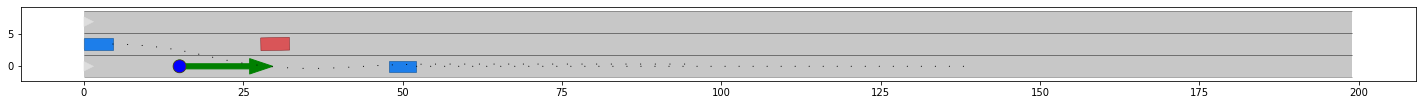

In [195]:
plt.figure(figsize=(25, 10))#! define renderer after figure creation
renderer = MPRenderer()
scenario.draw(renderer, draw_params={'time_begin': 0}) #! draw_params
planning_problem_set.draw(renderer, draw_params={'time_begin': 0}) 
renderer.draw_ellipse(initial_state.position, 1, 1, {'facecolor': 'blue'}, ()) # draw a circle
renderer.render()
plt.show()

## `Reference path`


Coordinates [x, y]:
[[0.00000e+00 0.00000e+00]
 [7.81250e-03 0.00000e+00]
 [2.34375e-02 0.00000e+00]
 ...
 [1.94000e+02 0.00000e+00]
 [1.94000e+02 0.00000e+00]
 [1.94000e+02 0.00000e+00]]


/home/wbh/anaconda3/envs/ss2022-commonroad-py37/lib/python3.7/site-packages/commonroad_route_planner/route.py:309: RuntimeWarning: invalid value encountered in true_divide
  return (x_d * y_dd - x_dd * y_d) / ((x_d ** 2 + y_d ** 2) ** (3. / 2.))


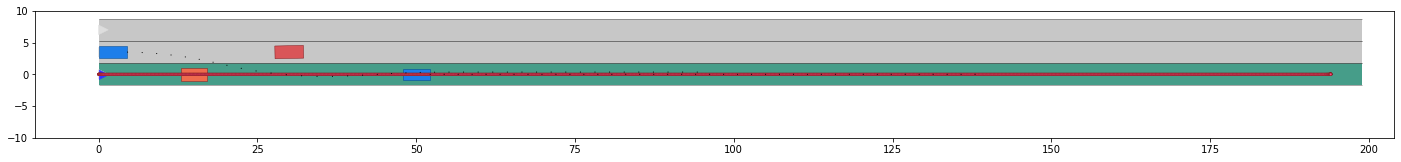

In [196]:
# create the curvilinear coordinate based on a reference path
route_planner = RoutePlanner(scenario, planning_problem, backend=RoutePlanner.Backend.NETWORKX_REVERSED)
#* NETWORKX: uses built-in functions from the networkx package, tends to change lanes later
#* NETWORKX_REVERSED: uses built-in functions from the networkx package, tends to change lanes earlier
#* PRIORITY_QUEUE: uses A-star search to find routes, lane change maneuver depends on the heuristic cost


# plan routes, and save the routes in a route candidate holder
candidate_holder = route_planner.plan_routes()
route = candidate_holder.retrieve_first_route()
ref_path = route.reference_path

print("\nCoordinates [x, y]:")
print(ref_path)  # 1584 * 2 
visualize_route(route, draw_route_lanelets=True, draw_reference_path=True, size_x=25)

#! Q:
#? The initial state defined in planning_problem is not the same as reference path's initial state


## `Reference path -> curveilinear system`

In [197]:
curvilinear_cosy = CurvilinearCoordinateSystem(ref_path, 25.0, 0.1) #* --> curv_sys
#* reference_path – 2D polyline in Cartesian coordinates
#* default_projection_domain_limit – maximum absolute distance of the projection domain border from the reference path, defaults to 20
#* eps – reduces the lateral distance of the projection domain border from the reference path, defaults to 0.1

print(len(curvilinear_cosy.projection_domain()))
print(curvilinear_cosy.reference_path()[-1])

curv_sys = curvilinear_cosy  # insert CurvilinearCoordinateSystem
# curv_sys.compute_and_set_curvature()
# print(curv_sys.get_curvature() )

3173
[194.   0.]


## `target lanelet`

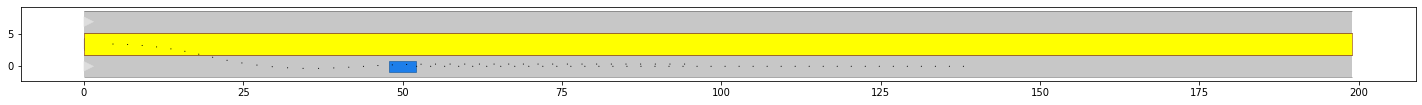

In [198]:

target_lanelet = scenario.lanelet_network.find_lanelet_by_id(2)  # TODO: insert target lane as Lanelet

#* Show target lanelet
plt.figure(figsize=(25, 10))#! define renderer after figure creation
renderer = MPRenderer()
scenario.draw(renderer, draw_params={'time_begin': 0}) #! draw_params
target_lanelet.convert_to_polygon().draw(renderer, draw_params={'facecolor': 'yellow'})
renderer.render()
plt.show()

In [199]:
init_state_curvlinear = CurvState(s=1.0, ds=5.0, dds=0.0)  # example; s: x-direction
nT=20 # n_time_steps
dt=0.1 # duration of each time_step


planner = MIQPPlanner(init_state_curvlinear, n_time_steps=nT, min_duration=[0.2, 1.0, 0.2], dt=dt, curv_sys=curv_sys)


# S_param = ScenarioParams()
# planner = MIQPPlanner(init_state_curvlinear, n_time_steps=nT, min_duration=[0.2, 1.0, 0.2], dt=dt, curv_sys=curv_sys, S_param) 


# longitudinal constraints
s_constraints = [np.array([[0, 20]]*30),  # initial lane  #! element shape 30 * 2, List length 3
                    np.array([[5, 20]]*30),  # during lane change
                    np.array([[5, 30]]*30)]  # target lane

planner.set_long_constraints(s_constraints)

In [200]:
planner.model.update()
# planner.model.display()

In [201]:
long_state_list, time_intervals = planner.solve_longitudinal()

Update succeeds.
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 284 rows, 143 columns and 858 nonzeros
Model fingerprint: 0x5ab45f47
Model has 40 quadratic objective terms
Variable types: 83 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 2e+01]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 3e+02]
Presolve removed 251 rows and 92 columns
Presolve time: 0.00s
Presolved: 33 rows, 51 columns, 124 nonzeros
Presolved model has 39 quadratic objective terms
Variable types: 51 continuous, 0 integer (0 binary)
Presolve time: 0.03s
Presolved: 33 rows, 51 columns, 124 nonzeros
Presolved model has 39 quadratic objective terms
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.200e+01
 Factor NZ  : 3.510e+02
 Factor Ops : 4.969e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective           

In [202]:
for i in range(3):
    print('mode {}:'.format(i), time_intervals[i].length+1)
print('----------------------------------------------')
targe_center_line = target_lanelet.center_vertices # TODO


mode 0: 8
mode 1: 10
mode 2: 2
----------------------------------------------


In [203]:
for v in planner.model.getVars():
    print(v.varName, v.X)

b0_0 1.0
b0_1 1.0
b0_2 1.0
b0_3 1.0
b0_4 1.0
b0_5 1.0
b0_6 1.0
b0_7 1.0
b0_8 1.0
b0_9 1.0
b0_10 1.0
b0_11 1.0
b0_12 1.0
b0_13 1.0
b0_14 1.0
b0_15 1.0
b0_16 1.0
b0_17 1.0
b0_18 1.0
b0_19 1.0
b1_0 0.0
b1_1 0.0
b1_2 0.0
b1_3 0.0
b1_4 0.0
b1_5 0.0
b1_6 0.0
b1_7 0.0
b1_8 1.0
b1_9 1.0
b1_10 1.0
b1_11 1.0
b1_12 1.0
b1_13 1.0
b1_14 1.0
b1_15 1.0
b1_16 1.0
b1_17 1.0
b1_18 1.0
b1_19 1.0
b2_0 0.0
b2_1 0.0
b2_2 0.0
b2_3 0.0
b2_4 0.0
b2_5 0.0
b2_6 0.0
b2_7 0.0
b2_8 0.0
b2_9 0.0
b2_10 0.0
b2_11 0.0
b2_12 0.0
b2_13 0.0
b2_14 0.0
b2_15 0.0
b2_16 0.0
b2_17 0.0
b2_18 1.0
b2_19 1.0
u0 8.992018839926175e-05
u1 -5.469958789916518e-06
u2 -1.3475109055249845e-05
u3 -1.4146770467959868e-05
u4 -1.4201559320525803e-05
u5 -1.4187364794082669e-05
u6 -1.3962241951048782e-05
u7 -1.1274962330887206e-05
u8 -2.9334920252921393e-06
u9 -2.461792938390772e-07
u10 -2.065936932638124e-08
u11 -1.7336834190473382e-09
u12 -1.454409925827349e-10
u13 -1.2168044349891716e-11
u14 -9.85878045867139e-13
u15 -6.217248937900877e-14
u

In [204]:
planner.solve_lateral(targe_center_line, time_intervals)
curvilinear_state_list = planner.states.state_list_cr

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 11 10:03:03 PM: Your problem has 83 variables, 100 constraints, and 0 parameters.
(CVXPY) May 11 10:03:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 10:03:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 10:03:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 10:03:03 PM: Compiling problem (target solver=OSQP).
(CVXPY) May 11 10:03:03 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

/home/wbh/anaconda3/envs/ss2022-commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: Lanes might diverge after s= 194.00029999999998!
/home/wbh/anaconda3/envs/ss2022-commonroad-py37/lib/python3.7/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 81 times so far.

  warnings.warn(msg, UserWarning)
/home/wbh/anaconda3/envs/ss2022-commonroad-py37/lib/python3.7/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar mu